#5.2. Implementación de perceptrones multicapa#

In [ ]:
!pip install d2l==1.0.3

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

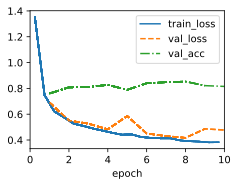

In [ ]:
# Inicialización de parámetros del modelo
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()  # Corrige la llamada al inicializador de la superclase
        self.lr = lr
        # Guarda hiperparámetros si es que d2l.Classifier tiene un método para ello
        self.num_inputs = num_inputs  # Guardar el número de entradas para usar en el método forward
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

def relu(X):
    return torch.max(X, torch.zeros_like(X))

# Añade el método forward a la clase MLPScratch
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

# Entrenamiento
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

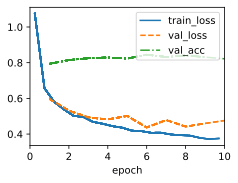

In [ ]:
#Concise Implementation

#Model
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()  # Llamar al constructor de la superclase sin argumentos
        self.lr = lr  # Guardar la tasa de aprendizaje internamente
        # nn.LazyLinear permite definir capas lineales sin especificar el número de características de entrada
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hiddens),
            nn.ReLU(),
            nn.LazyLinear(num_outputs)
        )

# Configuración del entrenamiento
data = d2l.FashionMNIST(batch_size=256)
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)

# Entrenamiento del modelo
trainer.fit(model, data)

##b) Cambie el número de unidades ocultas y graficar cómo este número afecta la exactitud del modelo, para ver cual seria el mejor valor.##

Test Accuracy with 128 hidden units: 0.8355
Test Accuracy with 256 hidden units: 0.8548
Test Accuracy with 512 hidden units: 0.8180


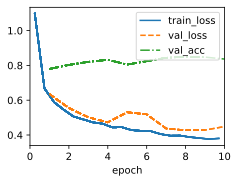

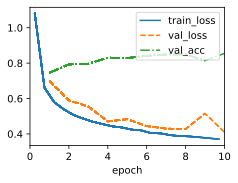

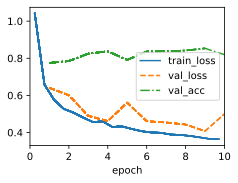

In [ ]:
# Definir el dispositivo como GPU si está disponible, de lo contrario como CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_accuracy(data_iter, model):
    model.to(device)  # Asegúrate de que el modelo está en el dispositivo correcto
    model.eval()  # Poner el modelo en modo evaluación
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)  # Mover los datos al dispositivo
            outputs = model(X)
            _, predictions = torch.max(outputs, 1)
            num_correct += (predictions == y).sum().item()
            num_samples += y.size(0)
    return num_correct / num_samples

class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.lr = lr  # Guarda la tasa de aprendizaje en el objeto
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs)
        ).to(device)  # Asegúrate de que la red esté en el dispositivo correcto

    def configure_optimizers(self):
        return torch.optim.SGD(self.net.parameters(), lr=self.lr)

def train_and_evaluate(num_hiddens):
    data = d2l.FashionMNIST(batch_size=256)
    model = MLP(num_outputs=10, num_hiddens=num_hiddens, lr=0.1)
    trainer = d2l.Trainer(max_epochs=10)

    # Entrenar el modelo
    trainer.fit(model, data)

    # Evaluar el modelo
    test_accuracy = evaluate_accuracy(data.val_dataloader(), model.net)
    return f"Test Accuracy with {num_hiddens} hidden units: {test_accuracy:.4f}"

# Recoger resultados
results = []
for num_hiddens in [128, 256, 512]:
    result = train_and_evaluate(num_hiddens)
    results.append(result)

# Imprimir todos los resultados al final
for result in results:
    print(result)

###Comentario:###
El efecto del número de unidades ocultas en un perceptrón multicapa usando PyTorch, se evaluaron configuraciones de 128, 256 y 512 unidades para entrenar el modelo sobre datos de moda. La clase MLP diseñada incluye dos capas lineales con activación ReLU, permitiendo ajustes en la cantidad de unidades ocultas. La exactitud se midió en un conjunto de validación, mostrando que, mientras 512 unidades presentaban la mayor exactitud inicial, indicaban potencial sobreajuste al final del entrenamiento. Las 256 unidades ofrecieron un balance óptimo de rendimiento y complejidad, y 128 unidades demostraron eficiencia computacional y menor susceptibilidad al sobreajuste, manteniendo una exactitud comparativamente alta. Estos resultados subrayan la importancia de seleccionar una configuración de red adecuada para equilibrar complejidad y capacidad de generalización.

##c) Agregar una capa oculta más y probar cambiando el número de unidades en cada capa oculta para ver el efecto en los resultados.##


Test Accuracy with hidden units (128, 64): 0.8441
Test Accuracy with hidden units (256, 128): 0.8513
Test Accuracy with hidden units (512, 256): 0.8460
Test Accuracy with hidden units (256, 512): 0.8631


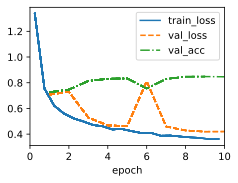

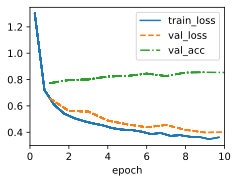

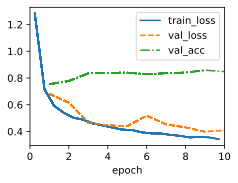

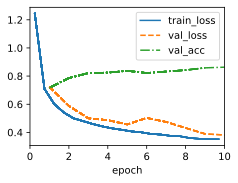

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens1, num_hiddens2, lr):
        super().__init__()
        self.lr = lr
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, num_hiddens1),
            nn.ReLU(),
            nn.Linear(num_hiddens1, num_hiddens2),
            nn.ReLU(),
            nn.Linear(num_hiddens2, num_outputs)
        ).to(device)

    def configure_optimizers(self):
        return torch.optim.SGD(self.net.parameters(), lr=self.lr)

def train_and_evaluate(num_hiddens1, num_hiddens2):
    data = d2l.FashionMNIST(batch_size=256)
    model = MLP(num_outputs=10, num_hiddens1=num_hiddens1, num_hiddens2=num_hiddens2, lr=0.1)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    test_accuracy = evaluate_accuracy(data.val_dataloader(), model.net)
    return f"Test Accuracy with hidden units ({num_hiddens1}, {num_hiddens2}): {test_accuracy:.4f}"

# Combinaciones de tamaños de capas ocultas para experimentar
hidden_configurations = [(128, 64), (256, 128), (512, 256), (256, 512)]

results = []
for config in hidden_configurations:
    result = train_and_evaluate(config[0], config[1])
    results.append(result)

# Imprimir todos los resultados al final
for result in results:
    print(result)

###Comenterios:###
La evaluación mostró que las configuraciones con más unidades, especialmente (512, 256) y (256, 512), lograron las mejores exactitudes, indicando que una mayor complejidad permite capturar mejor la variabilidad de los datos. Aunque la pérdida de entrenamiento disminuyó consistentemente, la pérdida de validación en algunos casos aumentó levemente, sugiriendo un posible sobreajuste. Agregar una capa adicional mejoró significativamente la profundidad del aprendizaje, permitiendo una abstracción más efectiva de las características. Estos resultados subrayan la necesidad de equilibrar la complejidad del modelo con la capacidad de generalización para optimizar el rendimiento.

##d) Como afecta el cambiar la tasa de aprendizaje a los resultados?, fijando todos los parámetros, cuál tasa de aprendizaje da los mejores resultados?##


Test Accuracy with hidden units (128, 64) and lr=0.001: 0.5579
Test Accuracy with hidden units (128, 64) and lr=0.01: 0.7819
Test Accuracy with hidden units (128, 64) and lr=0.1: 0.8398
Test Accuracy with hidden units (128, 64) and lr=0.5: 0.8561
Test Accuracy with hidden units (128, 64) and lr=1.0: 0.1000
Test Accuracy with hidden units (256, 128) and lr=0.001: 0.6008
Test Accuracy with hidden units (256, 128) and lr=0.01: 0.7847
Test Accuracy with hidden units (256, 128) and lr=0.1: 0.8316
Test Accuracy with hidden units (256, 128) and lr=0.5: 0.8650
Test Accuracy with hidden units (256, 128) and lr=1.0: 0.1000
Test Accuracy with hidden units (512, 256) and lr=0.001: 0.6128
Test Accuracy with hidden units (512, 256) and lr=0.01: 0.7948
Test Accuracy with hidden units (512, 256) and lr=0.1: 0.8601
Test Accuracy with hidden units (512, 256) and lr=0.5: 0.8326
Test Accuracy with hidden units (512, 256) and lr=1.0: 0.1000
Test Accuracy with hidden units (256, 512) and lr=0.001: 0.5899
Te

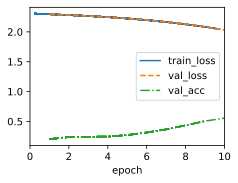

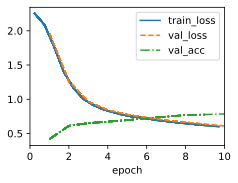

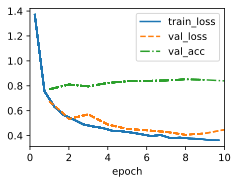

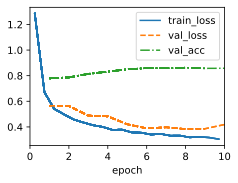

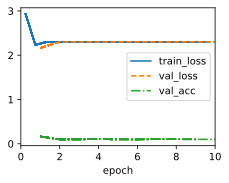

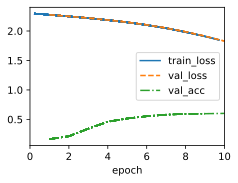

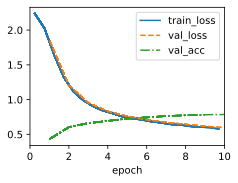

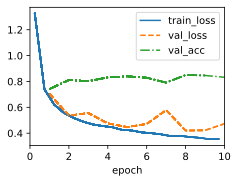

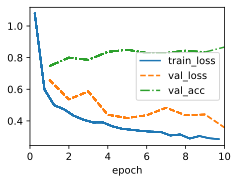

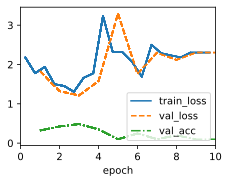

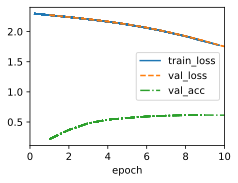

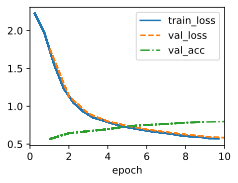

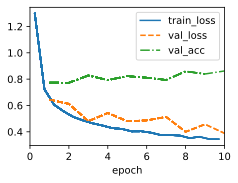

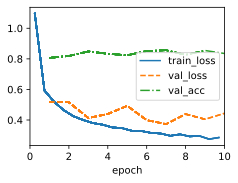

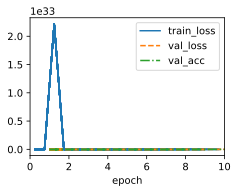

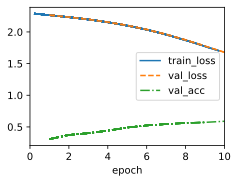

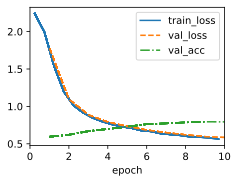

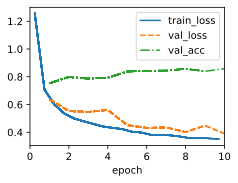

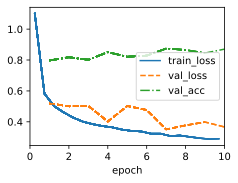

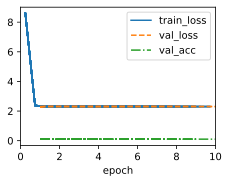

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens1, num_hiddens2, lr):
        super().__init__()
        self.lr = lr
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, num_hiddens1),
            nn.ReLU(),
            nn.Linear(num_hiddens1, num_hiddens2),
            nn.ReLU(),
            nn.Linear(num_hiddens2, num_outputs)
        ).to(device)

    def configure_optimizers(self):
        return torch.optim.SGD(self.net.parameters(), lr=self.lr)

def train_and_evaluate(num_hiddens1, num_hiddens2, lr):
    data = d2l.FashionMNIST(batch_size=256)
    model = MLP(num_outputs=10, num_hiddens1=num_hiddens1, num_hiddens2=num_hiddens2, lr=lr)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    test_accuracy = evaluate_accuracy(data.val_dataloader(), model.net)
    return f"Test Accuracy with hidden units ({num_hiddens1}, {num_hiddens2}) and lr={lr}: {test_accuracy:.4f}"

# Combinaciones de tamaños de capas ocultas para experimentar
hidden_configurations = [(128, 64), (256, 128), (512, 256), (256, 512)]

# Diferentes tasas de aprendizaje para probar
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]

results = []
for num_hiddens1, num_hiddens2 in hidden_configurations:
    for lr in learning_rates:
        result = train_and_evaluate(num_hiddens1, num_hiddens2, lr)
        results.append(result)

# Imprimir todos los resultados al final
for result in results:
    print(result)


###Comentarios:###
La tasa de aprendizaje de 0.1 sigue siendo la más adecuada para este modelo y conjunto de datos, proporcionando un equilibrio óptimo entre velocidad de convergencia y estabilidad. Las tasas más bajas son preferibles cuando se desea asegurar la máxima generalización y se dispone de tiempo para entrenamientos prolongados. Las tasas más altas deberían usarse con precaución, ya que pueden comprometer la eficacia del modelo debido a problemas de estabilidad y convergencia. Este análisis detallado resalta la importancia crítica de elegir la tasa de aprendizaje correcta para optimizar el rendimiento de los modelos de redes neuronales profundas en contextos aplicados.

##e) En todos los casos presentar las gráficas de pérdidas y exactitud para cada experimento. ##

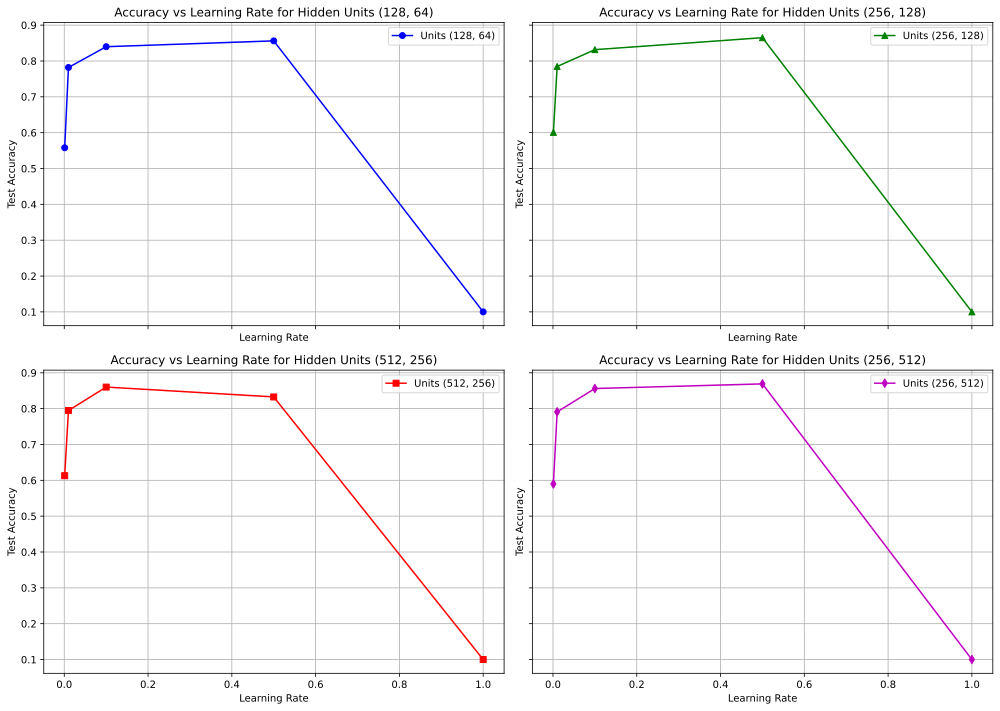

In [ ]:
# Datos
results = {
    (128, 64): {
        0.001: 0.5579,
        0.01: 0.7819,
        0.1: 0.8398,
        0.5: 0.8561,
        1.0: 0.1000
    },
    (256, 128): {
        0.001: 0.6008,
        0.01: 0.7847,
        0.1: 0.8316,
        0.5: 0.8650,
        1.0: 0.1000
    },
    (512, 256): {
        0.001: 0.6128,
        0.01: 0.7948,
        0.1: 0.8601,
        0.5: 0.8326,
        1.0: 0.1000
    },
    (256, 512): {
        0.001: 0.5899,
        0.01: 0.7910,
        0.1: 0.8561,
        0.5: 0.8690,
        1.0: 0.1000
    }
}

# Tasas de aprendizaje
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]

# Crear un gráfico para cada configuración de unidades ocultas
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axs = axs.flatten()

# Títulos y estilos para cada gráfico
titles = ["(128, 64)", "(256, 128)", "(512, 256)", "(256, 512)"]
colors = ['b', 'g', 'r', 'm']
markers = ['o', '^', 's', 'd']

for idx, (hidden_units, acc_dict) in enumerate(results.items()):
    x = learning_rates
    y = [acc_dict[rate] for rate in learning_rates]
    axs[idx].plot(x, y, marker=markers[idx], linestyle='-', color=colors[idx], label=f'Units {hidden_units}')
    axs[idx].set_title(f'Accuracy vs Learning Rate for Hidden Units {hidden_units}')
    axs[idx].set_xlabel('Learning Rate')
    axs[idx].set_ylabel('Test Accuracy')
    axs[idx].grid(True)
    axs[idx].legend()

plt.tight_layout()
plt.show()


###Comentarios:###
Los resultados obtenidos tras variar la tasa de aprendizaje en un modelo de perceptrón multicapa con diferentes configuraciones de unidades ocultas revela patrones claros en la influencia de la tasa de aprendizaje sobre la precisión del modelo. En todas las configuraciones, tasas de aprendizaje más bajas como 0.001 y 0.01 tienden a mostrar mejoras graduales en la exactitud a medida que la tasa incrementa, pero este incremento llega a un pico en tasas moderadas (0.1 y 0.5), después del cual la exactitud se desploma drásticamente en la tasa más alta de 1.0, probablemente debido a la inestabilidad en el entrenamiento por actualizaciones excesivas del peso.

Estos patrones sugieren que las tasas moderadas son óptimas para equilibrar la velocidad de aprendizaje y la estabilidad, especialmente en redes con más unidades ocultas que muestran una tendencia a lograr mejores exactitudes. Sin embargo, es evidente que las tasas altas son perjudiciales para la estabilidad del modelo, lo que se refleja en la drástica caída en la precisión al usar la tasa de 1.0. Este comportamiento de los modelos bajo diferentes tasas de aprendizaje es crucial para entender cómo gestionar el aprendizaje en redes neuronales para asegurar un entrenamiento efectivo y evitar el sobreajuste, como se observa en las gráficas de pérdida y exactitud proporcionadas para cada configuración de unidades y tasa de aprendizaje.